<a href="https://colab.research.google.com/github/r0cketr1kky/COVID-19_X-Ray/blob/master/smooth_scorecam_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
import os
import copy
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.jpg')
    save_image1(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', '/_Cam_Heatmap.png')
    save_image1(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', '/_Cam_On_Image.png')
    save_image1(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', '/_Cam_Grayscale.png')
    save_image1(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image1(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    #pretrained_model = model
    return (original_image,
            prep_img,
            target_class)
    
import torch
import torch.nn as nn


class BaseProp(object):
    """
        Base class for backpropagation.
    """

    def __init__(self, model):
        """Init
        # Arguments:
            model: torchvision.models. A pretrained model.
            handle: list. Handle list that register a hook function.
            relu_outputs: list. Forward output after relu.
        """
        self.model = model
        self.handle = []
        self.relu_outputs = []

    def _register_conv_hook(self):

        """
            Register hook function to save gradient w.r.t input image.
        """

        def _record_gradients(module, grad_in, grad_out):
                self.gradients = grad_in[0]

        for _, module in self.model.named_modules():
            if isinstance(module, nn.modules.conv.Conv2d) and module.in_channels == 3:
                backward_handle = module.register_backward_hook(_record_gradients)
                self.handle.append(backward_handle)

    def _register_relu_hooks(self):

        """
            Register hook function to save forward and backward relu result.
        """

        # Save forward propagation output of the ReLU layer
        def _record_output(module, input_, output):
            self.relu_outputs.append(output)

        def _clip_gradients(module, grad_in, grad_out):
            # keep positive forward propagation output
            relu_output = self.relu_outputs.pop()
            relu_output[relu_output > 0] = 1

            # keep positive backward propagation gradient
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)

            # generate modified guided gradient
            modified_grad_out = positive_grad_out * relu_output

            return (modified_grad_out, )

        for _, module in self.model.named_modules():
            if isinstance(module, nn.ReLU):
                forward_handle = module.register_forward_hook(_record_output)
                backward_handle = module.register_backward_hook(_clip_gradients)
                self.handle.append(forward_handle)
                self.handle.append(backward_handle)

class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

class Backprop(BaseProp):

    """ Generates vanilla or guided backprop gradients of a target class output w.r.t. an input image.
        # Arguments:
            model: torchvision.models. A pretrained model.
            guided: bool. If True, perform guided backpropagation. Defaults to False.
        # Return:
            Backprop Class.
    """

    def __init__(self, model, guided=False):
        super().__init__(model)
        self.model.eval()
        self.guided = guided
        self.gradients = None
        self._register_conv_hook()

    def calculate_gradients(self,
                            input_,
                            target_class=None,
                            take_max=False,
                            use_gpu=False):

        """ Calculate gradient.
            # Arguments
                input_: torch.Tensor. Preprocessed image with shape (1, C, H, W).
                target_class: int. Index of target class. Default to None and use the prediction result as target class.
                take_max: bool. Take the maximum across colour channels. Defaults to False.
                use_gpu. bool. Use GPU or not. Defaults to False.
            # Return:
                Gradient (torch.Tensor) with shape (C, H, W). If take max is True, with shape (1, H, W).
        """

        if self.guided:
            self._register_relu_hooks()

        # Create a empty tensor to save gradients
        self.gradients = torch.zeros(input_.shape)

        output = self.model(input_)

        self.model.zero_grad()

        if output.shape == torch.Size([1]):
            target = None
        else:
            pred_class = output.argmax().item()

            # Create a Tensor with zero elements, set the element at pred class index to be 1
            target = torch.zeros(output.shape)

            # If target class is None, calculate gradient of predicted class.
            if target_class is None:
                target[0][pred_class] = 1
            else:
                target[0][target_class] = 1

            
        # Calculate gradients w.r.t. input image
        output.backward(gradient=target)

        gradients = self.gradients.detach().cpu()[0]

        if take_max:
            gradients = gradients.max(dim=0, keepdim=True)[0]

        for module in self.handle:
            module.remove()
        gradients = gradients.numpy()
        return gradients

import numpy as np

from torch.autograd import Variable
import torch

from PIL import Image

# from guided_backprop import GuidedBackprop  # To use with guided backprop


def generate_smooth_grad(Backprop, prep_img, target_class, param_n, param_sigma_multiplier):
    """
        Generates smooth gradients of given Backprop type. You can use this with both vanilla
        and guided backprop
    Args:
        Backprop (class): Backprop type
        prep_img (torch Variable): preprocessed image
        target_class (int): target class of imagenet
        param_n (int): Amount of images used to smooth gradient
        param_sigma_multiplier (int): Sigma multiplier when calculating std of noise
    """
    # Generate an empty image/matrix
    smooth_grad = np.zeros(prep_img.size()[1:])

    mean = 0
    sigma = param_sigma_multiplier / (torch.max(prep_img) - torch.min(prep_img)).item()
    
    for x in range(param_n):
        # Generate noise
        noise = Variable(prep_img.data.new(prep_img.size()).normal_(mean, sigma**2))
        # Add noise to the image
        noisy_img = prep_img + noise
        # Calculate gradients
        vanilla_grads = Backprop.calculate_gradients(noisy_img, target_class)
        # Add gradients to smooth_grad
        smooth_grad = smooth_grad + vanilla_grads
    # Average it out
    smooth_grad = smooth_grad / param_n
    return smooth_grad

def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [0]:
#!/usr/bin/env python
"""flashtorch.utils

This module provides utility functions for image handling and tensor
transformation.

"""
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torchvision.models

def load_image(image_path):
    """Loads image as a PIL RGB image.

        Args:
            - **image_path (str) - **: A path to the image

        Returns:
            An instance of PIL.Image.Image in RGB

    """

    return Image.open(image_path).convert('RGB')


def apply_transforms(image, size=224):
    """Transforms a PIL image to torch.Tensor.

    Applies a series of tranformations on PIL image including a conversion
    to a tensor. The returned tensor has a shape of :math:`(N, C, H, W)` and
    is ready to be used as an input to neural networks.

    First the image is resized to 256, then cropped to 224. The `means` and
    `stds` for normalisation are taken from numbers used in ImageNet, as
    currently developing the package for visualizing pre-trained models.

    The plan is to to expand this to handle custom size/mean/std.

    Args:
        image (PIL.Image.Image or numpy array)
        size (int, optional, default=224): Desired size (width/height) of the
            output tensor

    Shape:
        Input: :math:`(C, H, W)` for numpy array
        Output: :math:`(N, C, H, W)`

    Returns:
        torch.Tensor (torch.float32): Transformed image tensor

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])

    tensor = transform(image).unsqueeze(0)

    tensor.requires_grad = True

    return tensor

def apply_transforms_v0(image, size=224):
    """Transforms a PIL image to torch.Tensor.

    Applies a series of tranformations on PIL image including a conversion
    to a tensor. The returned tensor has a shape of :math:`(N, C, H, W)` and
    is ready to be used as an input to neural networks.

    First the image is resized to 256, then cropped to 224. The `means` and
    `stds` for normalisation are taken from numbers used in ImageNet, as
    currently developing the package for visualizing pre-trained models.

    The plan is to to expand this to handle custom size/mean/std.

    Args:
        image (PIL.Image.Image or numpy array)
        size (int, optional, default=224): Desired size (width/height) of the
            output tensor

    Shape:
        Input: :math:`(C, H, W)` for numpy array
        Output: :math:`(N, C, H, W)`

    Returns:
        torch.Tensor (torch.float32): Transformed image tensor

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    if not isinstance(image, Image.Image):
        image = F.to_pil_image(image)

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor()
    ])

    tensor = transform(image).unsqueeze(0)

    tensor.requires_grad = True

    return tensor


def denormalize(tensor):
    """Reverses the normalisation on a tensor.

    Performs a reverse operation on a tensor, so the pixel value range is
    between 0 and 1. Useful for when plotting a tensor into an image.

    Normalisation: (image - mean) / std
    Denormalisation: image * std + mean

    Args:
        tensor (torch.Tensor, dtype=torch.float32): Normalized image tensor

    Shape:
        Input: :math:`(N, C, H, W)`
        Output: :math:`(N, C, H, W)` (same shape as input)

    Return:
        torch.Tensor (torch.float32): Demornalised image tensor with pixel
            values between [0, 1]

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    denormalized = tensor.clone()

    for channel, mean, std in zip(denormalized[0], means, stds):
        channel.mul_(std).add_(mean)

    return denormalized


def standardize_and_clip(tensor, min_value=0.0, max_value=1.0):
    """Standardizes and clips input tensor.

    Standardize the input tensor (mean = 0.0, std = 1.0), ensures std is 0.1
    and clips it to values between min/max (default: 0.0/1.0).

    Args:
        tensor (torch.Tensor):
        min_value (float, optional, default=0.0)
        max_value (float, optional, default=1.0)

    Shape:
        Input: :math:`(C, H, W)`
        Output: Same as the input

    Return:
        torch.Tensor (torch.float32): Normalised tensor with values between
            [min_value, max_value]

    """

    tensor = tensor.detach().cpu()

    mean = tensor.mean()
    std = tensor.std()
    if std == 0:
        std += 1e-7

    standardized = tensor.sub(mean).div(std).mul(0.1)
    clipped = standardized.add(0.5).clamp(min_value, max_value)

    return clipped


def format_for_plotting(tensor):
    """Formats the shape of tensor for plotting.

    Tensors typically have a shape of :math:`(N, C, H, W)` or :math:`(C, H, W)`
    which is not suitable for plotting as images. This function formats an
    input tensor :math:`(H, W, C)` for RGB and :math:`(H, W)` for mono-channel
    data.

    Args:
        tensor (torch.Tensor, torch.float32): Image tensor

    Shape:
        Input: :math:`(N, C, H, W)` or :math:`(C, H, W)`
        Output: :math:`(H, W, C)` or :math:`(H, W)`, respectively

    Return:
        torch.Tensor (torch.float32): Formatted image tensor (detached)

    Note:
        Symbols used to describe dimensions:
            - N: number of images in a batch
            - C: number of channels
            - H: height of the image
            - W: width of the image

    """

    has_batch_dimension = len(tensor.shape) == 4
    formatted = tensor.clone()

    if has_batch_dimension:
        formatted = tensor.squeeze(0)

    if formatted.shape[0] == 1:
        return formatted.squeeze(0).detach()
    else:
        return formatted.permute(1, 2, 0).detach()


def visualize(input_, gradients, save_path=None, cmap='viridis', alpha=0.7):

    """ Method to plot the explanation.

        # Arguments
            input_: Tensor. Original image.
            gradients: Tensor. Saliency map result.
            save_path: String. Defaults to None.
            cmap: Defaults to be 'viridis'.
            alpha: Defaults to be 0.7.

    """

    input_ = format_for_plotting(denormalize(input_))
    gradients = format_for_plotting(standardize_and_clip(gradients))

    subplots = [
        ('Input image', [(input_, None, None)]),
        ('Saliency map across RGB channels', [(gradients, None, None)]),
        ('Overlay', [(input_, None, None), (gradients, cmap, alpha)])
    ]

    num_subplots = len(subplots)

    fig = plt.figure(figsize=(16, 3))

    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, num_subplots, i + 1)
        ax.set_axis_off()

        for image, cmap, alpha in images:
            ax.imshow(image, cmap=cmap, alpha=alpha)

        ax.set_title(title)
    if save_path is not None:
        plt.savefig(save_path)


def basic_visualize(input_, gradients, save_path=None, weight=None, cmap='viridis', alpha=0.7):

    """ Method to plot the explanation.

        # Arguments
            input_: Tensor. Original image.
            gradients: Tensor. Saliency map result.
            save_path: String. Defaults to None.
            cmap: Defaults to be 'viridis'.
            alpha: Defaults to be 0.7.

    """
    input_ = format_for_plotting(denormalize(input_))
    gradients = format_for_plotting(standardize_and_clip(gradients))

    subplots = [
        ('Saliency map across RGB channels', [(gradients, None, None)]),
        ('Overlay', [(input_, None, None), (gradients, cmap, alpha)])
    ]

    num_subplots = len(subplots)

    fig = plt.figure(figsize=(4, 4))
    count=0
    for i, (title, images) in enumerate(subplots):
        ax = fig.add_subplot(1, num_subplots, i + 1)
        ax.set_axis_off()

        for image, cmap, alpha in images:
            print('hello {}'.format(count))
            count+=1
            ax.imshow(image, cmap=cmap, alpha=alpha)

    if save_path is not None:
        plt.savefig(save_path)

    return images


def find_resnet_layer(arch, target_layer_name):
    """Find resnet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'conv1'
            target_layer_name = 'layer1'
            target_layer_name = 'layer1_basicblock0'
            target_layer_name = 'layer1_basicblock0_relu'
            target_layer_name = 'layer1_bottleneck0'
            target_layer_name = 'layer1_bottleneck0_conv1'
            target_layer_name = 'layer1_bottleneck0_downsample'
            target_layer_name = 'layer1_bottleneck0_downsample_0'
            target_layer_name = 'avgpool'
            target_layer_name = 'fc'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'layer4'

    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        if layer_num == 1:
            target_layer = arch.layer1
        elif layer_num == 2:
            target_layer = arch.layer2
        elif layer_num == 3:
            target_layer = arch.layer3
        elif layer_num == 4:
            target_layer = arch.layer4
        else:
            raise ValueError('unknown layer : {}'.format(target_layer_name))

        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]

        if len(hierarchy) >= 3:
            target_layer = target_layer._modules[hierarchy[2]]

        if len(hierarchy) == 4:
            target_layer = target_layer._modules[hierarchy[3]]

    else:
        target_layer = arch._modules[target_layer_name]

    return target_layer


def find_densenet_layer(arch, target_layer_name):
    """Find densenet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_transition1'
            target_layer_name = 'features_transition1_norm'
            target_layer_name = 'features_denseblock2_denselayer12'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'features_denseblock2_denselayer12_norm1'
            target_layer_name = 'classifier'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """

    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) >= 3:
        target_layer = target_layer._modules[hierarchy[2]]

    if len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[3]]

    return target_layer


def find_vgg_layer(arch, target_layer_name):
    """Find vgg layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_42'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_alexnet_layer(arch, target_layer_name):
    """Find alexnet layer to calculate GradCAM and GradCAM++

    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_0'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'

    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features_29'

    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.features

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer


def find_squeezenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision densenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'features_12'
                target_layer_name = 'features_12_expand3x3'
                target_layer_name = 'features_12_expand3x3_activation'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_googlenet_layer(arch, target_layer_name):
    """Find squeezenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'inception5b'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_mobilenet_layer(arch, target_layer_name):
    """Find mobilenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'features'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_shufflenet_layer(arch, target_layer_name):
    """Find mobilenet layer to calculate GradCAM and GradCAM++

        Args:
            - **arch - **: default torchvision googlenet models
            - **target_layer_name (str) - **: the name of layer with its hierarchical information. please refer to usages below.
                target_layer_name = 'conv5'

        Return:
            target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    if target_layer_name is None:
        target_layer_name = 'features'

    hierarchy = target_layer_name.split('_')
    target_layer = arch._modules[hierarchy[0]]

    if len(hierarchy) >= 2:
        target_layer = target_layer._modules[hierarchy[1]]

    if len(hierarchy) == 3:
        target_layer = target_layer._modules[hierarchy[2]]

    elif len(hierarchy) == 4:
        target_layer = target_layer._modules[hierarchy[2] + '_' + hierarchy[3]]

    return target_layer


def find_layer(arch, target_layer_name):
    """Find target layer to calculate CAM.

        : Args:
            - **arch - **: Self-defined architecture.
            - **target_layer_name - ** (str): Name of target class.

        : Return:
            - **target_layer - **: Found layer. This layer will be hooked to get forward/backward pass information.
    """

    if target_layer_name.split('_') not in arch._modules.keys():
        raise Exception("Invalid target layer name.")
    target_layer = arch._modules[target_layer_name]
    return target_layer
'''
Part of code borrows from https://github.com/1Konny/gradcam_plus_plus-pytorch
'''

import torch

class BaseCAM(object):
    """ Base class for Class activation mapping.
        : Args
            - **model_dict -** : Dict. Has format as dict(type='vgg', arch=torchvision.models.vgg16(pretrained=True),
            layer_name='features',input_size=(224, 224)).
    """

    def __init__(self, model_dict):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        
        self.model_arch = model_dict['arch']
        self.model_arch.eval()
        #if torch.cuda.is_available():
        #  self.model_arch.cuda()
        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            #if torch.cuda.is_available():
            #  self.gradients['value'] = grad_output[0].cuda()
            
            self.gradients['value'] = grad_output[0]
            
            return None

        def forward_hook(module, input, output):
            #if torch.cuda.is_available():
            #  self.activations['value'] = output.cuda()
            self.activations['value'] = output
            
            return None

        if 'vgg' in model_type.lower():
            self.target_layer = find_vgg_layer(self.model_arch, layer_name)
        elif 'resnet' in model_type.lower():
            self.target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
            self.target_layer = find_densenet_layer(self.model_arch, layer_name)
        elif 'alexnet' in model_type.lower():
            self.target_layer = find_alexnet_layer(self.model_arch, layer_name)
        elif 'squeezenet' in model_type.lower():
            self.target_layer = find_squeezenet_layer(self.model_arch, layer_name)
        elif 'googlenet' in model_type.lower():
            self.target_layer = find_googlenet_layer(self.model_arch, layer_name)
        elif 'shufflenet' in model_type.lower():
            self.target_layer = find_shufflenet_layer(self.model_arch, layer_name)
        elif 'mobilenet' in model_type.lower():
            self.target_layer = find_mobilenet_layer(self.model_arch, layer_name)
        else:
            self.target_layer = find_layer(self.model_arch, layer_name)

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def forward(self, input, class_idx=None, retain_graph=False):
        return None

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

import torch.nn.functional as F

class GradCAM(BaseCAM):
    """
        GradCAM, inherit from BaseCAM
    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input_, class_idx=None, retain_graph=False):
        """Generates GradCAM result.

        # Arguments
            input_: torch.Tensor. Preprocessed image with shape (1, C, H, W).
            class_idx: int. Index of target class. Defaults to be index of predicted class.

        # Return
            Result of GradCAM (torch.Tensor) with shape (1, H, W).
        """

        b, c, h, w = input_.size()
        logit = self.model_arch(input_)

        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)

        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights * activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map


class ScoreCAM(BaseCAM):

    """
        ScoreCAM, inherit from BaseCAM

    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model_arch(input)
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            predicted_class = torch.LongTensor([class_idx])
            score = logit[:, class_idx].squeeze()
        
        logit = F.softmax(logit)

        #if torch.cuda.is_available():
        #  predicted_class= predicted_class.cuda()
        #  score = score.cuda()
        #  logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        activations = self.activations['value']
        b, k, u, v = activations.size()
        
        score_saliency_map = torch.zeros((1, 1, h, w))

        #if torch.cuda.is_available():
        #  activations = activations.cuda()
        #  score_saliency_map = score_saliency_map.cuda()

        with torch.no_grad():
          for i in range(k):

              # upsampling
              saliency_map = torch.unsqueeze(activations[:, i, :, :], 1)
              saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
              
              if saliency_map.max() == saliency_map.min():
                continue
              
              # normalize to 0-1
              norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

              # how much increase if keeping the highlighted region
              # predication on masked input
              output = self.model_arch(input * norm_saliency_map)
              output = F.softmax(output)
              score = output[0][predicted_class]

              score_saliency_map +=  score * saliency_map
                
        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data

        return score_saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

import torch
import torch.nn.functional as F


class ScoreCAM1(BaseCAM):

    """
        ScoreCAM, inherit from BaseCAM

    """

    def __init__(self, model_dict):
        super().__init__(model_dict)

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()
        
        # predication on raw input
        logit = self.model_arch(input)
        
        if class_idx is None:
            predicted_class = logit.max(1)[-1]
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            predicted_class = torch.LongTensor([class_idx])
            score = logit[:, class_idx].squeeze()
        
        logit = F.softmax(logit)

        #if torch.cuda.is_available():
        #  predicted_class= predicted_class.cuda()
        #  score = score.cuda()
        #  logit = logit.cuda()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        activations = self.activations['value']
        b1, k, u, v = activations.size()
        gradients = self.gradients['value']
        b2, k1, u1, v1 = gradients.size()

        score_saliency_map = torch.zeros((1, 1, h, w))

        #if torch.cuda.is_available():
        #  activations = activations.cuda()
        #  score_saliency_map = score_saliency_map.cuda()

        print(activations.size())
        print(gradients.size())
        #smooth = torch.zeros((1,k,u,v))
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        '''
        mean = 0
        param_sigma_multiplier = 4
        '''
        with torch.no_grad():
          for i in range(k):

              # upsampling
              saliency_map1 = torch.unsqueeze(activations[:, i, :, :], 1)
              
              #noise = Variable(smooth.data.new((h,w).normal_(mean, sigma**2)))
              '''
              sigma = param_sigma_multiplier / (torch.max(gradients) - torch.min(gradients)).item()              
              noise = torch.empty((k,u,v)).normal_(mean=mean,std=sigma)
              noisy_img = smooth + noise
              
              #print(noisy_img.shape)

              gradients = noisy_img + gradients
              '''
              saliency_map2 = torch.unsqueeze(gradients[:, i, :, :], 1)
              saliency_map3 = (weights * activations).sum(1, keepdim=True)
              saliency_map = torch.mul(saliency_map1, saliency_map2)
              saliency_map = torch.mul(saliency_map, saliency_map3)
              
              saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
              
              if saliency_map.max() == saliency_map.min():
                continue
              
              # normalize to 0-1
              norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

              # how much increase if keeping the highlighted region
              # predication on masked input
              output = self.model_arch(input * norm_saliency_map)
              output = F.softmax(output)
              score = output[0][predicted_class]

              score_saliency_map +=  score * saliency_map
                
        score_saliency_map = F.relu(score_saliency_map)
        score_saliency_map_min, score_saliency_map_max = score_saliency_map.min(), score_saliency_map.max()

        if score_saliency_map_min == score_saliency_map_max:
            return None

        score_saliency_map = (score_saliency_map - score_saliency_map_min).div(score_saliency_map_max - score_saliency_map_min).data

        return score_saliency_map

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

In [0]:
listscore = []
avg_drop = []
avg_drop_sc = []
count1 = 0

In [0]:
import cv2
from PIL import Image

In [0]:
def get_activation_map(image_path, \
                       model_path='/gdrive/My Drive/mobilenet-rocket-chess-2.pt', \
                       model_type='mobilenet', \
                       layer_name='features', \
                       target_class=2):
  '''
  # model_path -
   VGG16 CHESS = '/gdrive/My Drive/vgg16-rocket-chess_2.pt'
   MOBILENET CHESS = '/gdrive/My Drive/mobilenet-rocket-chess-2.pt'
   PNEUMONIA DENSENET =  '/gdrive/My Drive/densenet-rocket-3.pt'
   PNEUMONIA GOOGLENET =  '/gdrive/My Drive/googlenet-rocket-1.pt'


  # model_type - 
   VGG16 = 'vgg16' or 'vgg'(whichever works, preferably 1st option)
   Mobilenet = 'mobilenet'
   Densenet = 'densenet'
   Googlenet = 'googlenet'

  # layer_name - 
   VGG16 - 'features_29'
   Mobilenet - 'features'
   Densenet - 'features'
   Googlenet - 'inception5b'

  #target_class 
  Chess =   0 - Bishop
            1 - King
            2 - Knight
            3 - Pawn
            4 - Queen
            5 - Rook

  Pneumonia = 0 - Normal
              1 - Pneumonia


  '''

  from torchvision import transforms, datasets, models
  import torch
  from torch import optim, cuda
  from torch.utils.data import DataLoader, sampler
  import torch.nn as nn

  import warnings
  warnings.filterwarnings('ignore', category=FutureWarning)

  # Data science tools
  import numpy as np
  import pandas as pd
  import os

  # Image manipulations
  from PIL import Image
  # Useful for examining network
  from torchsummary import summary
  # Timing utility
  from timeit import default_timer as timer

  # Visualizations
  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.rcParams['font.size'] = 14

  model = torch.load(model_path)

  X = model.eval()

  x_model_dict = dict(type=model_type, arch=X, layer_name=layer_name, input_size=(224, 224))

  x_scorecam = ScoreCAM(x_model_dict)

  input_image = load_image(image_path)
  print('Image Path-->{}'.format(image_path))
  input_ = apply_transforms(input_image)
  #print(input_)
  original_image =  Image.open(image_path)
  prep_img = preprocess_image(original_image)
  
  predicted_score = X(input_).max(1)[0]
  listscore.append(predicted_score)
  #predicted_class = X(input_).max(1)[-1]
  #predicted_class = 1+predicted_class
  
  print(X(input_).max(1))
  
  scorecam_map = x_scorecam(input_)
  
  #scorecam_image = basic_visualize(input_.cpu(), \
  #                                 scorecam_map.type(torch.FloatTensor).cpu())
  
  param_n = 50
  param_sigma_multiplier = 4

  GBP = Backprop(model, guided=True)
  
  smooth_grad = generate_smooth_grad(GBP,  # ^This parameter
                                    prep_img,
                                    target_class,
                                    param_n,
                                    param_sigma_multiplier)
  #print(smooth_grad)

  grayscale_smooth_grad = convert_to_grayscale(smooth_grad)

  model_dict =  dict(type=model_type, arch=X, layer_name=layer_name, input_size=(224, 224))


  #print(smooth_grad.shape)
  #smooth_grad = torch.FloatTensor(smooth_grad)

  #smooth_grad.unsqueeze_(0)

  save_image1(smooth_grad, "./My Drive/grayscalesmooth.jpg")

  input_im = load_image("./My Drive/grayscalesmooth.jpg")
  input_gray = apply_transforms(input_im)
  '''
  gradcam = GradCAM(model_dict)
  gradcam1 = gradcam(input_gray)

  from torchvision.utils import save_image
  import torch
  import torchvision
  img1 = gradcam1[0]
  # img1 = img1.numpy() # TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>
  save_image(img1, "./My Drive/gradcamimage.jpg")
  input_im = load_image("./My Drive/gradcamimage.jpg")
  input_cam = apply_transforms(input_im)
  '''
  x_scorecam1 = ScoreCAM1(x_model_dict)

  scorecam_map1 = x_scorecam1(input_gray)
  scorecam_image = basic_visualize(input_.cpu(), \
                                   scorecam_map1.type(torch.FloatTensor).cpu())    
  #print(scorecam_map)
  #print(scorecam_map1)
  
  mask_intensity = 50
  print("ScoreCAM completed")

  seg = scorecam_map1[0][0].numpy().astype(np.float32)
  #plt.imshow(seg)
  img = Image.fromarray(np.uint8(seg * 255) , 'L')
  #plt.imshow(img)
  img.save('./My Drive/saved_img.jpg')
  arr = cv2.imread('./My Drive/saved_img.jpg',cv2.IMREAD_GRAYSCALE)
  #print(arr)
  mask =np.where(arr>mask_intensity,1,0)

  global count1
  Yci = listscore[count1]
  Yci = torch.exp(Yci)
  #Yci = 1+Yci
  print(Yci)
  img = Image.fromarray(np.uint8(mask * 255) , 'L')
  img.save('./My Drive/saved_mask.jpg')
  
  im = load_image('./My Drive/saved_mask.jpg')
  #print(im.shape)
  m = apply_transforms(im)

  Oci = X(m).max(1)[0]
  Oci = torch.exp(Oci)
  #Oci = 1+Oci
  print(Oci)
  print(Yci - Oci)
  avg_drop.append(((max(0, Yci - Oci))/(Yci)))
  print(((max(0, Yci - Oci))/(Yci)))


  seg = scorecam_map[0][0].numpy().astype(np.float32)
  #plt.imshow(seg)
  img = Image.fromarray(np.uint8(seg * 255) , 'L')
  #plt.imshow(img)
  img.save('./My Drive/saved_img.jpg')
  arr = cv2.imread('./My Drive/saved_img.jpg',cv2.IMREAD_GRAYSCALE)
  #print(arr)
  mask =np.where(arr>mask_intensity,1,0)
  img = Image.fromarray(np.uint8(mask * 255) , 'L')
  img.save('./My Drive/saved_mask.jpg')
  im = load_image('./My Drive/saved_mask.jpg')
  #print(im.shape)
  m = apply_transforms(im)

  Oci = X(m).max(1)[0]
  Oci = torch.exp(Oci)
  #Oci = 1+Oci
  print(Oci)
  print(Yci - Oci)
  avg_drop_sc.append(((max(0, Yci - Oci))/(Yci)))
  print(((max(0, Yci - Oci))/(Yci)))
  
  count1 += 1

  return

Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000005.png
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0013], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9987], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.6678], grad_fn=<SubBackward0>)
tensor([0.6687], grad_fn=<DivBackward0>)
tensor([0.4968], grad_fn=<ExpBackward>)
tensor([0.5019], grad_fn=<SubBackward0>)
tensor([0.5026], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000002.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0011], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9989], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.6680], grad_fn=<SubBackward0>)
tensor([0.6687], grad_fn=<DivBackward0>)
tensor([0.8794], grad_fn=<ExpBackward>)
tensor([0.1194], grad_fn=<SubBackward0>)
tensor([0.1196], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000010.JPG
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.4251], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.6537], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.3228], grad_fn=<SubBackward0>)
tensor([0.4938], grad_fn=<DivBackward0>)
tensor([0.6177], grad_fn=<ExpBackward>)
tensor([0.0360], grad_fn=<SubBackward0>)
tensor([0.0551], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000001.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0057], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9943], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.6634], grad_fn=<SubBackward0>)
tensor([0.6672], grad_fn=<DivBackward0>)
tensor([0.3484], grad_fn=<ExpBackward>)
tensor([0.6459], grad_fn=<SubBackward0>)
tensor([0.6496], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000019.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0172], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9830], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.6520], grad_fn=<SubBackward0>)
tensor([0.6634], grad_fn=<DivBackward0>)
tensor([0.6642], grad_fn=<ExpBackward>)
tensor([0.3187], grad_fn=<SubBackward0>)
tensor([0.3243], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000009.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0182], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9820], grad_fn=<ExpBackward>)
tensor([0.3158], grad_fn=<ExpBackward>)
tensor([0.6662], grad_fn=<SubBackward0>)
tensor([0.6784], grad_fn=<DivBackward0>)
tensor([0.7613], grad_fn=<ExpBackward>)
tensor([0.2207], grad_fn=<SubBackward0>)
tensor([0.2248], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000006.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0454], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9556], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.6247], grad_fn=<SubBackward0>)
tensor([0.6537], grad_fn=<DivBackward0>)
tensor([0.7376], grad_fn=<ExpBackward>)
tensor([0.2181], grad_fn=<SubBackward0>)
tensor([0.2282], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000013.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0004], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9996], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.6687], grad_fn=<SubBackward0>)
tensor([0.6690], grad_fn=<DivBackward0>)
tensor([0.6441], grad_fn=<ExpBackward>)
tensor([0.3555], grad_fn=<SubBackward0>)
tensor([0.3556], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000008.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.2210], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.8017], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.4708], grad_fn=<SubBackward0>)
tensor([0.5872], grad_fn=<DivBackward0>)
tensor([0.3562], grad_fn=<ExpBackward>)
tensor([0.4455], grad_fn=<SubBackward0>)
tensor([0.5557], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000000.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.3496], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.7050], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.3741], grad_fn=<SubBackward0>)
tensor([0.5306], grad_fn=<DivBackward0>)
tensor([0.6027], grad_fn=<ExpBackward>)
tensor([0.1023], grad_fn=<SubBackward0>)
tensor([0.1451], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000018.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.4982], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.6076], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.2767], grad_fn=<SubBackward0>)
tensor([0.4554], grad_fn=<DivBackward0>)
tensor([0.8336], grad_fn=<ExpBackward>)
tensor([-0.2259], grad_fn=<SubBackward0>)
tensor([0.], grad_fn=<MulBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000021.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0025], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9975], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.6666], grad_fn=<SubBackward0>)
tensor([0.6683], grad_fn=<DivBackward0>)
tensor([0.3970], grad_fn=<ExpBackward>)
tensor([0.6005], grad_fn=<SubBackward0>)
tensor([0.6020], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000023.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.2183], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.8039], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.4730], grad_fn=<SubBackward0>)
tensor([0.5884], grad_fn=<DivBackward0>)
tensor([0.3283], grad_fn=<ExpBackward>)
tensor([0.4756], grad_fn=<SubBackward0>)
tensor([0.5916], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000022.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0176], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9825], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.6516], grad_fn=<SubBackward0>)
tensor([0.6632], grad_fn=<DivBackward0>)
tensor([0.8907], grad_fn=<ExpBackward>)
tensor([0.0918], grad_fn=<SubBackward0>)
tensor([0.0934], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000017.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0078], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9922], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.6613], grad_fn=<SubBackward0>)
tensor([0.6665], grad_fn=<DivBackward0>)
tensor([0.7949], grad_fn=<ExpBackward>)
tensor([0.1973], grad_fn=<SubBackward0>)
tensor([0.1988], grad_fn=<DivBackward0>)
Image Path-->/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/00000012.jpg
could not transform PIL_img to a PIL Image object. Please check input.
torch.return_types.max(
values=tensor([-0.0435], grad_fn=<MaxBackward0>),
indices=tensor([2]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:820: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 1280, 7, 7])
torch.Size([1, 1280, 7, 7])
hello 0
hello 1
hello 2
ScoreCAM completed
tensor([0.9574], grad_fn=<ExpBackward>)
tensor([0.3309], grad_fn=<ExpBackward>)
tensor([0.6265], grad_fn=<SubBackward0>)
tensor([0.6544], grad_fn=<DivBackward0>)
tensor([0.4266], grad_fn=<ExpBackward>)
tensor([0.5308], grad_fn=<SubBackward0>)
tensor([0.5544], grad_fn=<DivBackward0>)


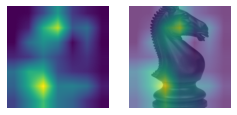

In [24]:
f = os.listdir('/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/')
for i in f:
  get_activation_map('/gdrive/My Drive/Chessman-image-dataset/Chess_test/Knight/'+i)

In [25]:
avg_drop

[tensor([0.6687], grad_fn=<DivBackward0>),
 tensor([0.6687], grad_fn=<DivBackward0>),
 tensor([0.4938], grad_fn=<DivBackward0>),
 tensor([0.6672], grad_fn=<DivBackward0>),
 tensor([0.6634], grad_fn=<DivBackward0>),
 tensor([0.6784], grad_fn=<DivBackward0>),
 tensor([0.6537], grad_fn=<DivBackward0>),
 tensor([0.6690], grad_fn=<DivBackward0>),
 tensor([0.5872], grad_fn=<DivBackward0>),
 tensor([0.5306], grad_fn=<DivBackward0>),
 tensor([0.4554], grad_fn=<DivBackward0>),
 tensor([0.6683], grad_fn=<DivBackward0>),
 tensor([0.5884], grad_fn=<DivBackward0>),
 tensor([0.6632], grad_fn=<DivBackward0>),
 tensor([0.6665], grad_fn=<DivBackward0>),
 tensor([0.6544], grad_fn=<DivBackward0>)]

In [26]:
avg_drop

[tensor([0.6687], grad_fn=<DivBackward0>),
 tensor([0.6687], grad_fn=<DivBackward0>),
 tensor([0.4938], grad_fn=<DivBackward0>),
 tensor([0.6672], grad_fn=<DivBackward0>),
 tensor([0.6634], grad_fn=<DivBackward0>),
 tensor([0.6784], grad_fn=<DivBackward0>),
 tensor([0.6537], grad_fn=<DivBackward0>),
 tensor([0.6690], grad_fn=<DivBackward0>),
 tensor([0.5872], grad_fn=<DivBackward0>),
 tensor([0.5306], grad_fn=<DivBackward0>),
 tensor([0.4554], grad_fn=<DivBackward0>),
 tensor([0.6683], grad_fn=<DivBackward0>),
 tensor([0.5884], grad_fn=<DivBackward0>),
 tensor([0.6632], grad_fn=<DivBackward0>),
 tensor([0.6665], grad_fn=<DivBackward0>),
 tensor([0.6544], grad_fn=<DivBackward0>)]

In [27]:
sum(avg_drop) / len(avg_drop)

tensor([0.6236], grad_fn=<DivBackward0>)

In [28]:
avg_drop_sc

[tensor([0.5026], grad_fn=<DivBackward0>),
 tensor([0.1196], grad_fn=<DivBackward0>),
 tensor([0.0551], grad_fn=<DivBackward0>),
 tensor([0.6496], grad_fn=<DivBackward0>),
 tensor([0.3243], grad_fn=<DivBackward0>),
 tensor([0.2248], grad_fn=<DivBackward0>),
 tensor([0.2282], grad_fn=<DivBackward0>),
 tensor([0.3556], grad_fn=<DivBackward0>),
 tensor([0.5557], grad_fn=<DivBackward0>),
 tensor([0.1451], grad_fn=<DivBackward0>),
 tensor([0.], grad_fn=<MulBackward0>),
 tensor([0.6020], grad_fn=<DivBackward0>),
 tensor([0.5916], grad_fn=<DivBackward0>),
 tensor([0.0934], grad_fn=<DivBackward0>),
 tensor([0.1988], grad_fn=<DivBackward0>),
 tensor([0.5544], grad_fn=<DivBackward0>)]

In [29]:
sum(avg_drop_sc) / len(avg_drop_sc)

tensor([0.3251], grad_fn=<DivBackward0>)